1.1 Exploratory Data Analysis (EDA)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [2]:
from keras.datasets import fashion_mnist
(train_img, train_label), (test_img, test_label) = fashion_mnist.load_data()

In [3]:
x_data= np.load('./data/train_images.npy')
print("Training (meta) data: ", x_data.shape)
y_data = pd.read_csv('./data/train_labels.csv', delimiter=',')

x_test = np.load('./data/test_images.npy')
print("Test (meta) data: ", x_test.shape)

# Show first rows of data

y_data.head(10)

Training (meta) data:  (60000, 28, 28)
Test (meta) data:  (10000, 28, 28)


,label
0,9
1,0
2,0
3,3
4,0
5,2
6,7
7,2
8,5
9,5


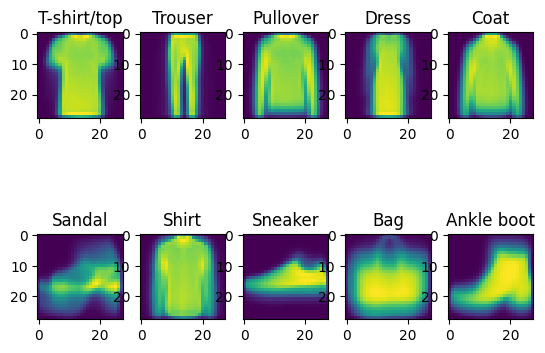

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

figure, axis = plt.subplots(2, 5)
k = 0
for i in range(2):
    for j in range(5):
        axis[i,j].imshow(x_data[y_data.label.values == k,...].mean(axis=0))
        axis[i,j].grid(False)
        axis[i,j].set_title(class_names[k])
        k += 1

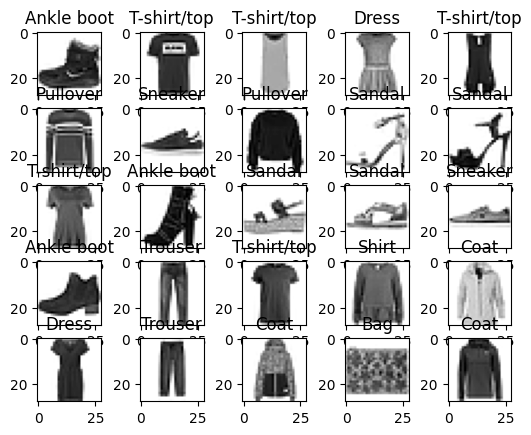

In [5]:
figure, axis = plt.subplots(5, 5)
k = 0
for i in range(5):
    for j in range(5):
        axis[i,j].imshow(x_data[k], cmap=plt.cm.binary)
        axis[i,j].grid(False)
        axis[i,j].set_title(class_names[y_data.label[k]])
        k += 1
plt.show()

Histograma de distribución de clases: las clases son equiprobables.

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

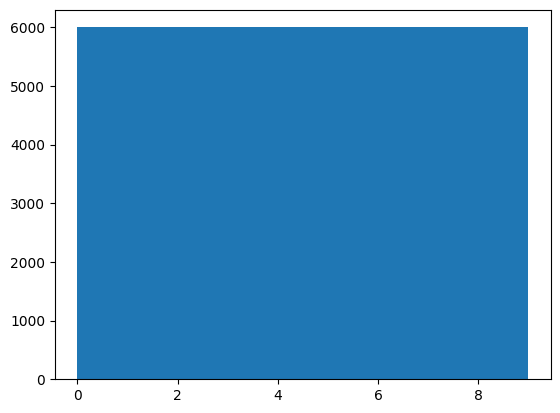

In [6]:
plt.hist(y_data['label']) 

Data splitting: train/validation datasets:
Training data — used for training the model
Validation data — used for tuning the hyperparameters and evaluate the models

In [7]:
# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x_data.shape[0]*(1-validation))
# Training Set
x_train = x_data[:N_validation_split]
y_train = y_data[:N_validation_split]

# Cross Validation Set
x_val = x_data[N_validation_split:]
y_val = y_data[N_validation_split:]
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)

Training set data: (48000, 28, 28)
Training labels: (48000, 1)

CV set data: (12000, 28, 28)
CV labels: (12000, 1)


Data normalization

In [8]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Normalizing the data
#sc = StandardScaler()
#x_train = sc.fit_transform(x_train.values)

MLP: let's start!

One-hot encoding

In [9]:
y_train_categorical = np_utils.to_categorical(y_train['label'])
y_val_categorical = np_utils.to_categorical(y_val)
print(y_train_categorical.shape)
for i in range(10):
    print(y_train['label'][i], y_train_categorical[i])

(48000, 10)
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.
https://datascience.stackexchange.com/questions/37378/what-are-kernel-initializers-and-what-is-their-significance 

Softmax regression:

In [10]:
K.clear_session()

model_0 = classification_model(       x_train.shape,
                            output_size = 10,
                            hidden_layers_size = 0, 
                            hidden_layers_units = [0],
                            hidden_activation = 'sigmoid',
                            kernel_initializer= 'random_normal',
                            dropout_rate = 0.0,
                            regularizer = None,
                            regularizer_rate = 0.001,
                            bias_initializer = 'zeros',
                            use_batch_normalization=False,
                            lr = 0.001,
                            decay = 0, 
                            out_softmax = True
                            )
model_0.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Accuracy of model previous to training

In [11]:
score = model_0.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])


loss:  2.686384916305542
accuracy:  0.10000000149011612


Let's train this single layer

In [12]:
model_0.fit(x_train, 
                       y_train_categorical,
                       epochs=500, batch_size=128, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[callback_EarlyStopping()],
                      )

Epoch 1/500
375/375 [==============================] - 5s 9ms/step - loss: 0.8042 - accuracy: 0.7375 - f1_m: 0.6585 - precision_m: 0.8577 - recall_m: 0.5605 - val_loss: 0.5804 - val_accuracy: 0.8073 - val_f1_m: 0.7821 - val_precision_m: 0.8810 - val_recall_m: 0.7037
Epoch 2/500
375/375 [==============================] - 2s 5ms/step - loss: 0.5400 - accuracy: 0.8219 - f1_m: 0.8051 - precision_m: 0.8819 - recall_m: 0.7412 - val_loss: 0.5110 - val_accuracy: 0.8284 - val_f1_m: 0.8178 - val_precision_m: 0.8837 - val_recall_m: 0.7614
Epoch 3/500
375/375 [==============================] - 2s 6ms/step - loss: 0.4902 - accuracy: 0.8364 - f1_m: 0.8267 - precision_m: 0.8862 - recall_m: 0.7750 - val_loss: 0.4834 - val_accuracy: 0.8375 - val_f1_m: 0.8278 - val_precision_m: 0.8813 - val_recall_m: 0.7808
Epoch 4/500
375/375 [==============================] - 2s 5ms/step - loss: 0.4658 - accuracy: 0.8427 - f1_m: 0.8363 - precision_m: 0.8873 - recall_m: 0.7912 - val_loss: 0.4596 - val_accuracy: 0.8442 

Last run: 
Epoch 50/500
375/375 - 1s - loss: 0.3607 - accuracy: 0.8726 - f1_m: 0.5126 - precision_m: 0.3493 - recall_m: 0.9634 - val_loss: 0.4167 - val_accuracy: 0.8553 - val_f1_m: 0.5116 - val_precision_m: 0.3492 - val_recall_m: 0.9578 - 1s/epoch - 4ms/step

One hidden layer model: 50 neurons.

KeyError: ''

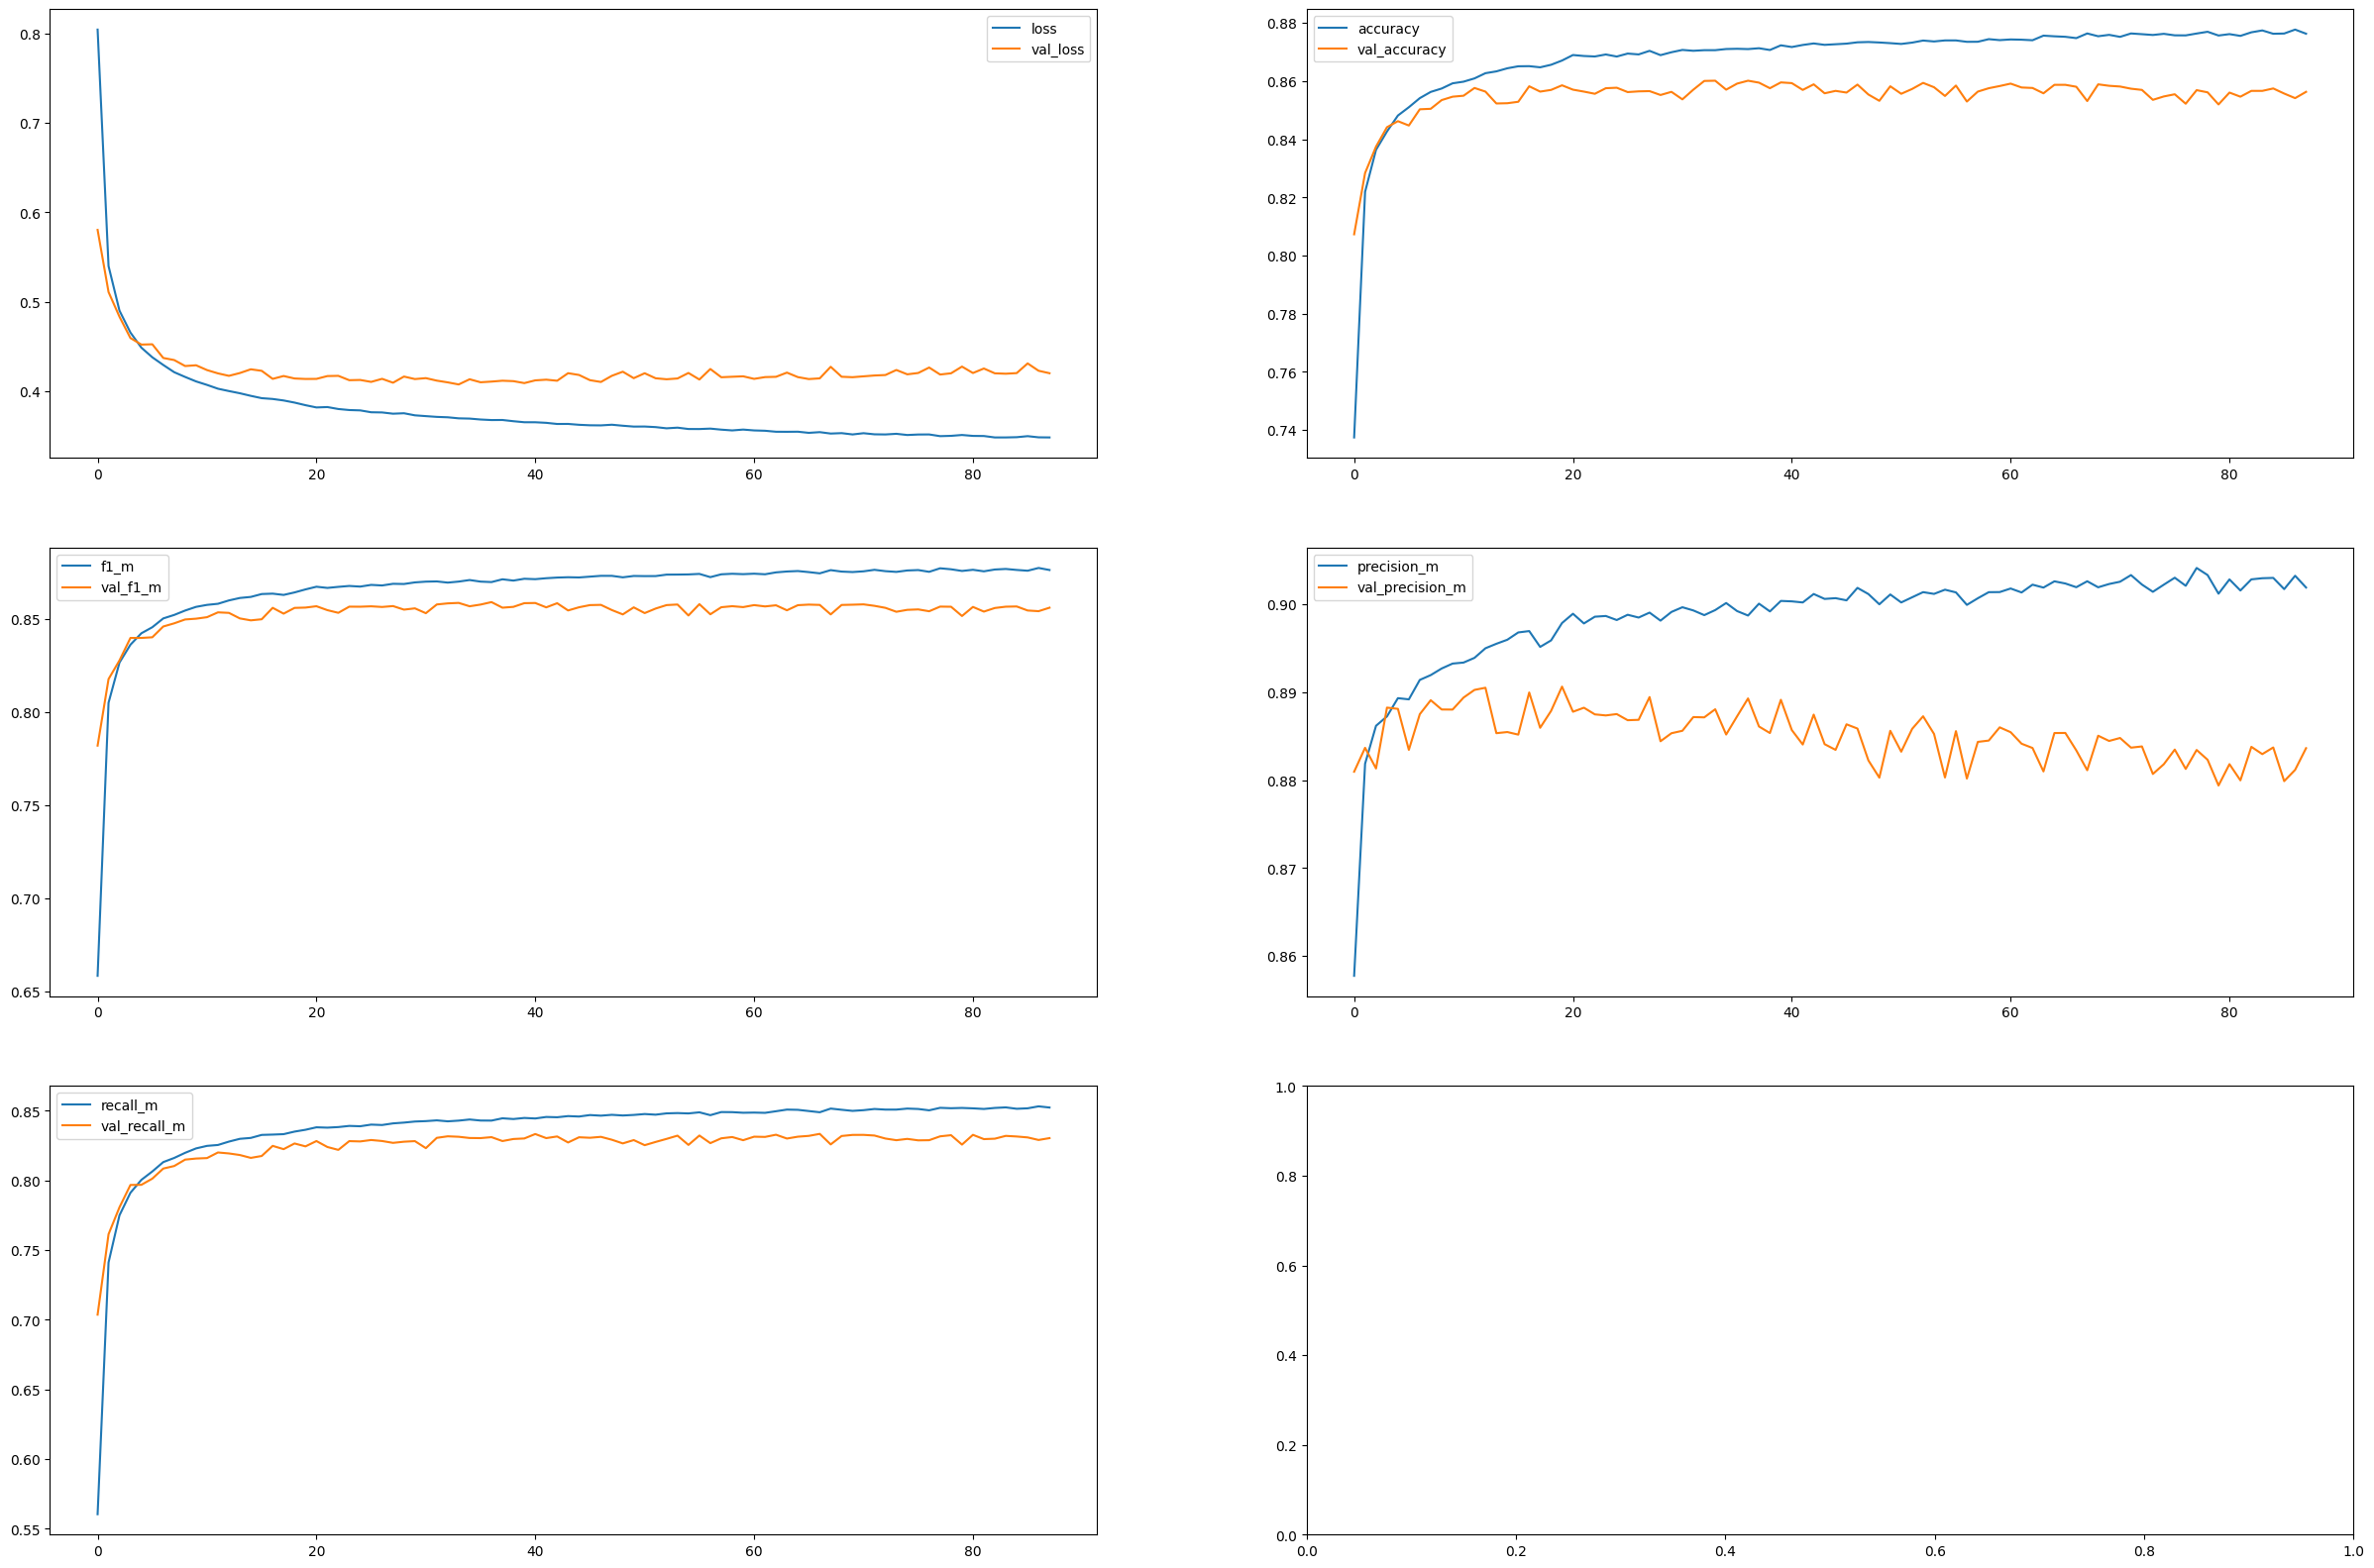

In [13]:
metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_0.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_0.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1


Graficos accuracy vs cosas

In [ ]:
learning_rate = [1, 0.1, 0.01, 0.001]
batch_size = [1028, 512, 256, 128, 64]
optimizers = ["SGD", "Adam", "Adagrad", "Adamax"]
activation_functions = ['sigmoid','tanh','relu']
dropout_rate = [0, 0.1, 0.25, 0.5, 0.75]
batch_normalization = [False, True]
weight_init = []

f, axis = plt.subplots(3,2, figsize=(30, 20))

#learning rate
for i in range(len(learning_rate)):
    K.clear_session()
    model = classification_model( x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0, 
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = learning_rate[i],
                                    decay = 0, 
                                    out_softmax = True
                                    )
    model.fit(x_train, 
                       y_train_categorical,
                       epochs=500, batch_size=128, 
                       verbose=0, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[callback_EarlyStopping()],
                      )
    axis[0,0].plot(model_0.history.history['val_accuracy'], label = "LR = " + str(learning_rate[i]))

axis[0,0].legend()

#batch size
for i in range(len(batch_size)):
    K.clear_session()
    model = classification_model( x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0, 
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = 0.001,
                                    decay = 0, 
                                    out_softmax = True
                                    )
    model.fit(x_train, 
                       y_train_categorical,
                       epochs=500, batch_size=batch_size[i], 
                       verbose=0, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[callback_EarlyStopping()],
                      )
    axis[0,1].plot(model_0.history.history['val_accuracy'], label = "Batch size = " + str(batch_size[i]))
    
axis[0,1].legend()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
375/375 - 4s - loss: 0.6990 - accuracy: 0.7769 - f1_m: 0.4627 - precision_m: 0.3036 - recall_m: 0.9776 - val_loss: 0.4860 - val_accuracy: 0.8232 - val_f1_m: 0.5030 - val_precision_m: 0.3372 - val_recall_m: 0.9897 - 4s/epoch - 10ms/step
Epoch 2/500
375/375 - 2s - loss: 0.4416 - accuracy: 0.8435 - f1_m:

KeyError: ''

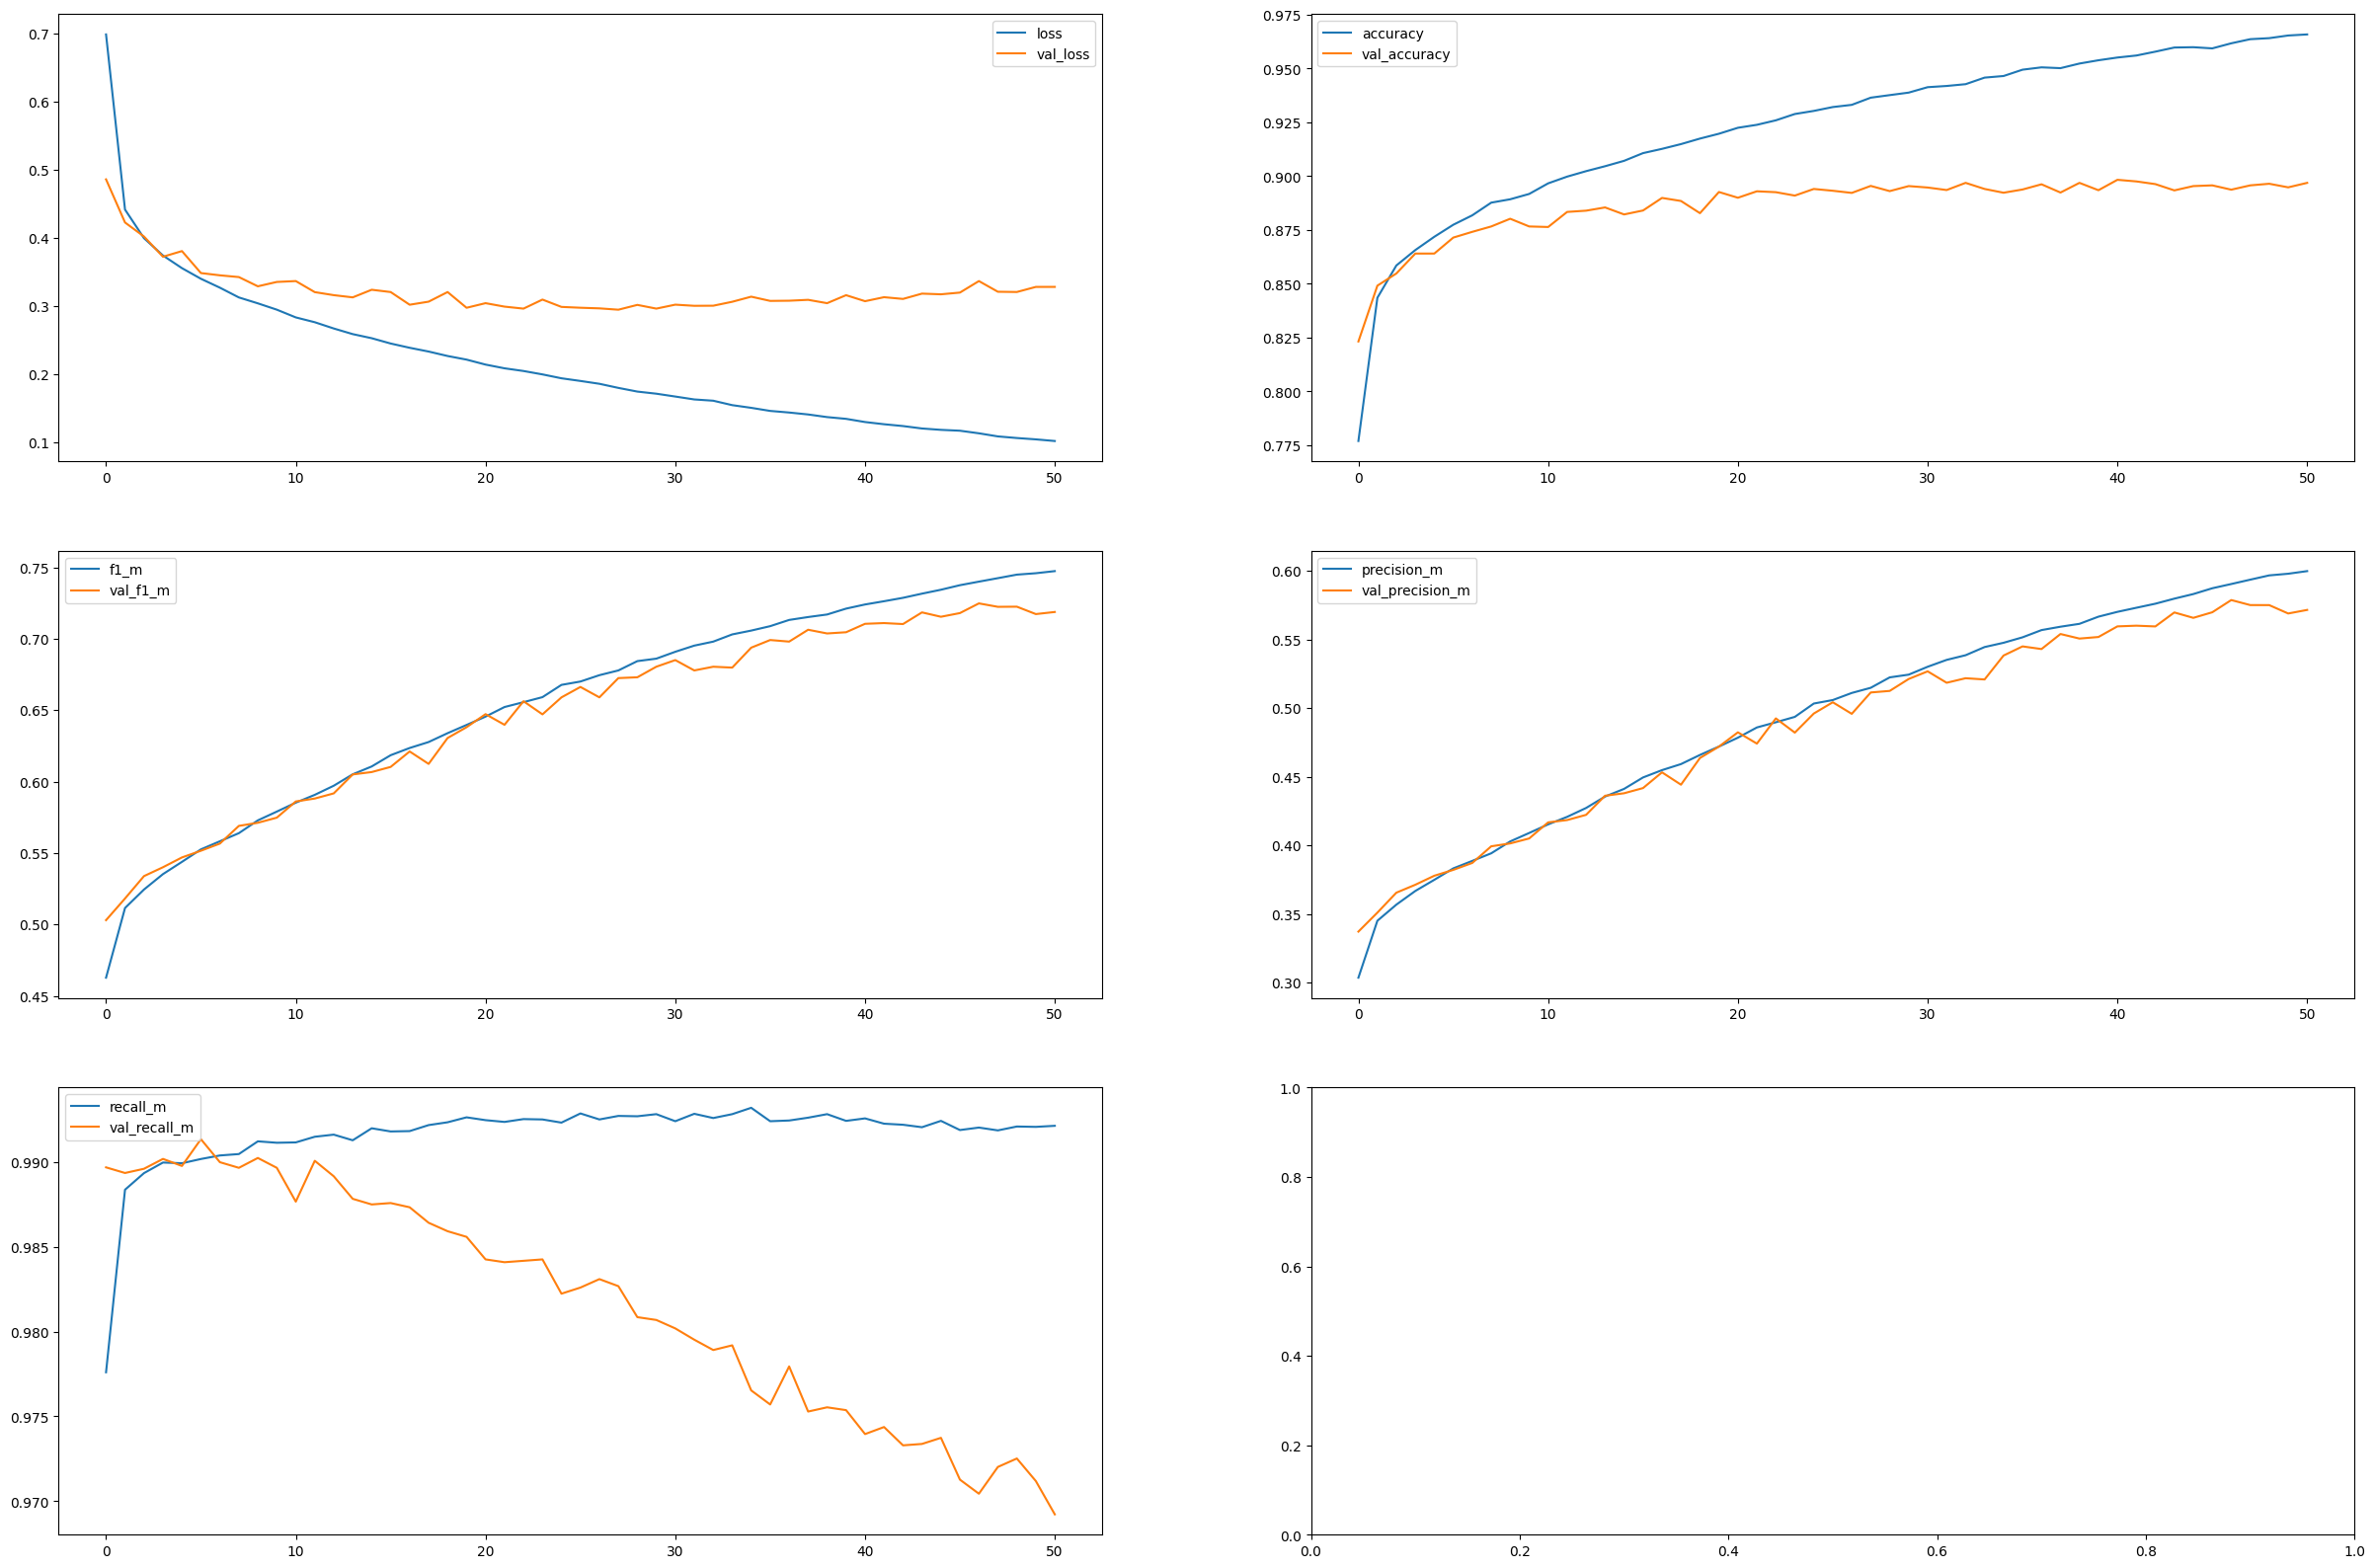

In [ ]:
K.clear_session()

model_1 = classification_model(       x_train.shape,
                            output_size = 10,
                            hidden_layers_size = 1, 
                            hidden_layers_units = [256],
                            hidden_activation = 'sigmoid',
                            kernel_initializer= 'random_normal',
                            dropout_rate = 0.0,
                            regularizer = None,
                            regularizer_rate = 0.001,
                            bias_initializer = 'zeros',
                            use_batch_normalization=False,
                            lr = 0.001,
                            decay = 0, 
                            out_softmax = False
                            )
model_1.summary()

model_1.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()])

metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_1.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_1.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1

As expected, it was better! 
Epoch 46/500
375/375 - 1s - loss: 0.2056 - accuracy: 0.9261 - val_loss: 0.3182 - val_accuracy: 0.8871 - 1s/epoch - 4ms/step

But there was a terrific overfitting starting from the very first epochs! Let's try to solve it before going on.

Let's add a Droupout rate of 0.25.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
375/375 - 4s - loss: 0.7348 - accuracy: 0.7566 - f1_m: 0.4478 - precision_m: 0.2910 - recall_m: 0.9803 - val_loss: 0.4917 - val_accuracy: 0.8238 - val_f1_m: 0.4941 - val_

KeyError: ''

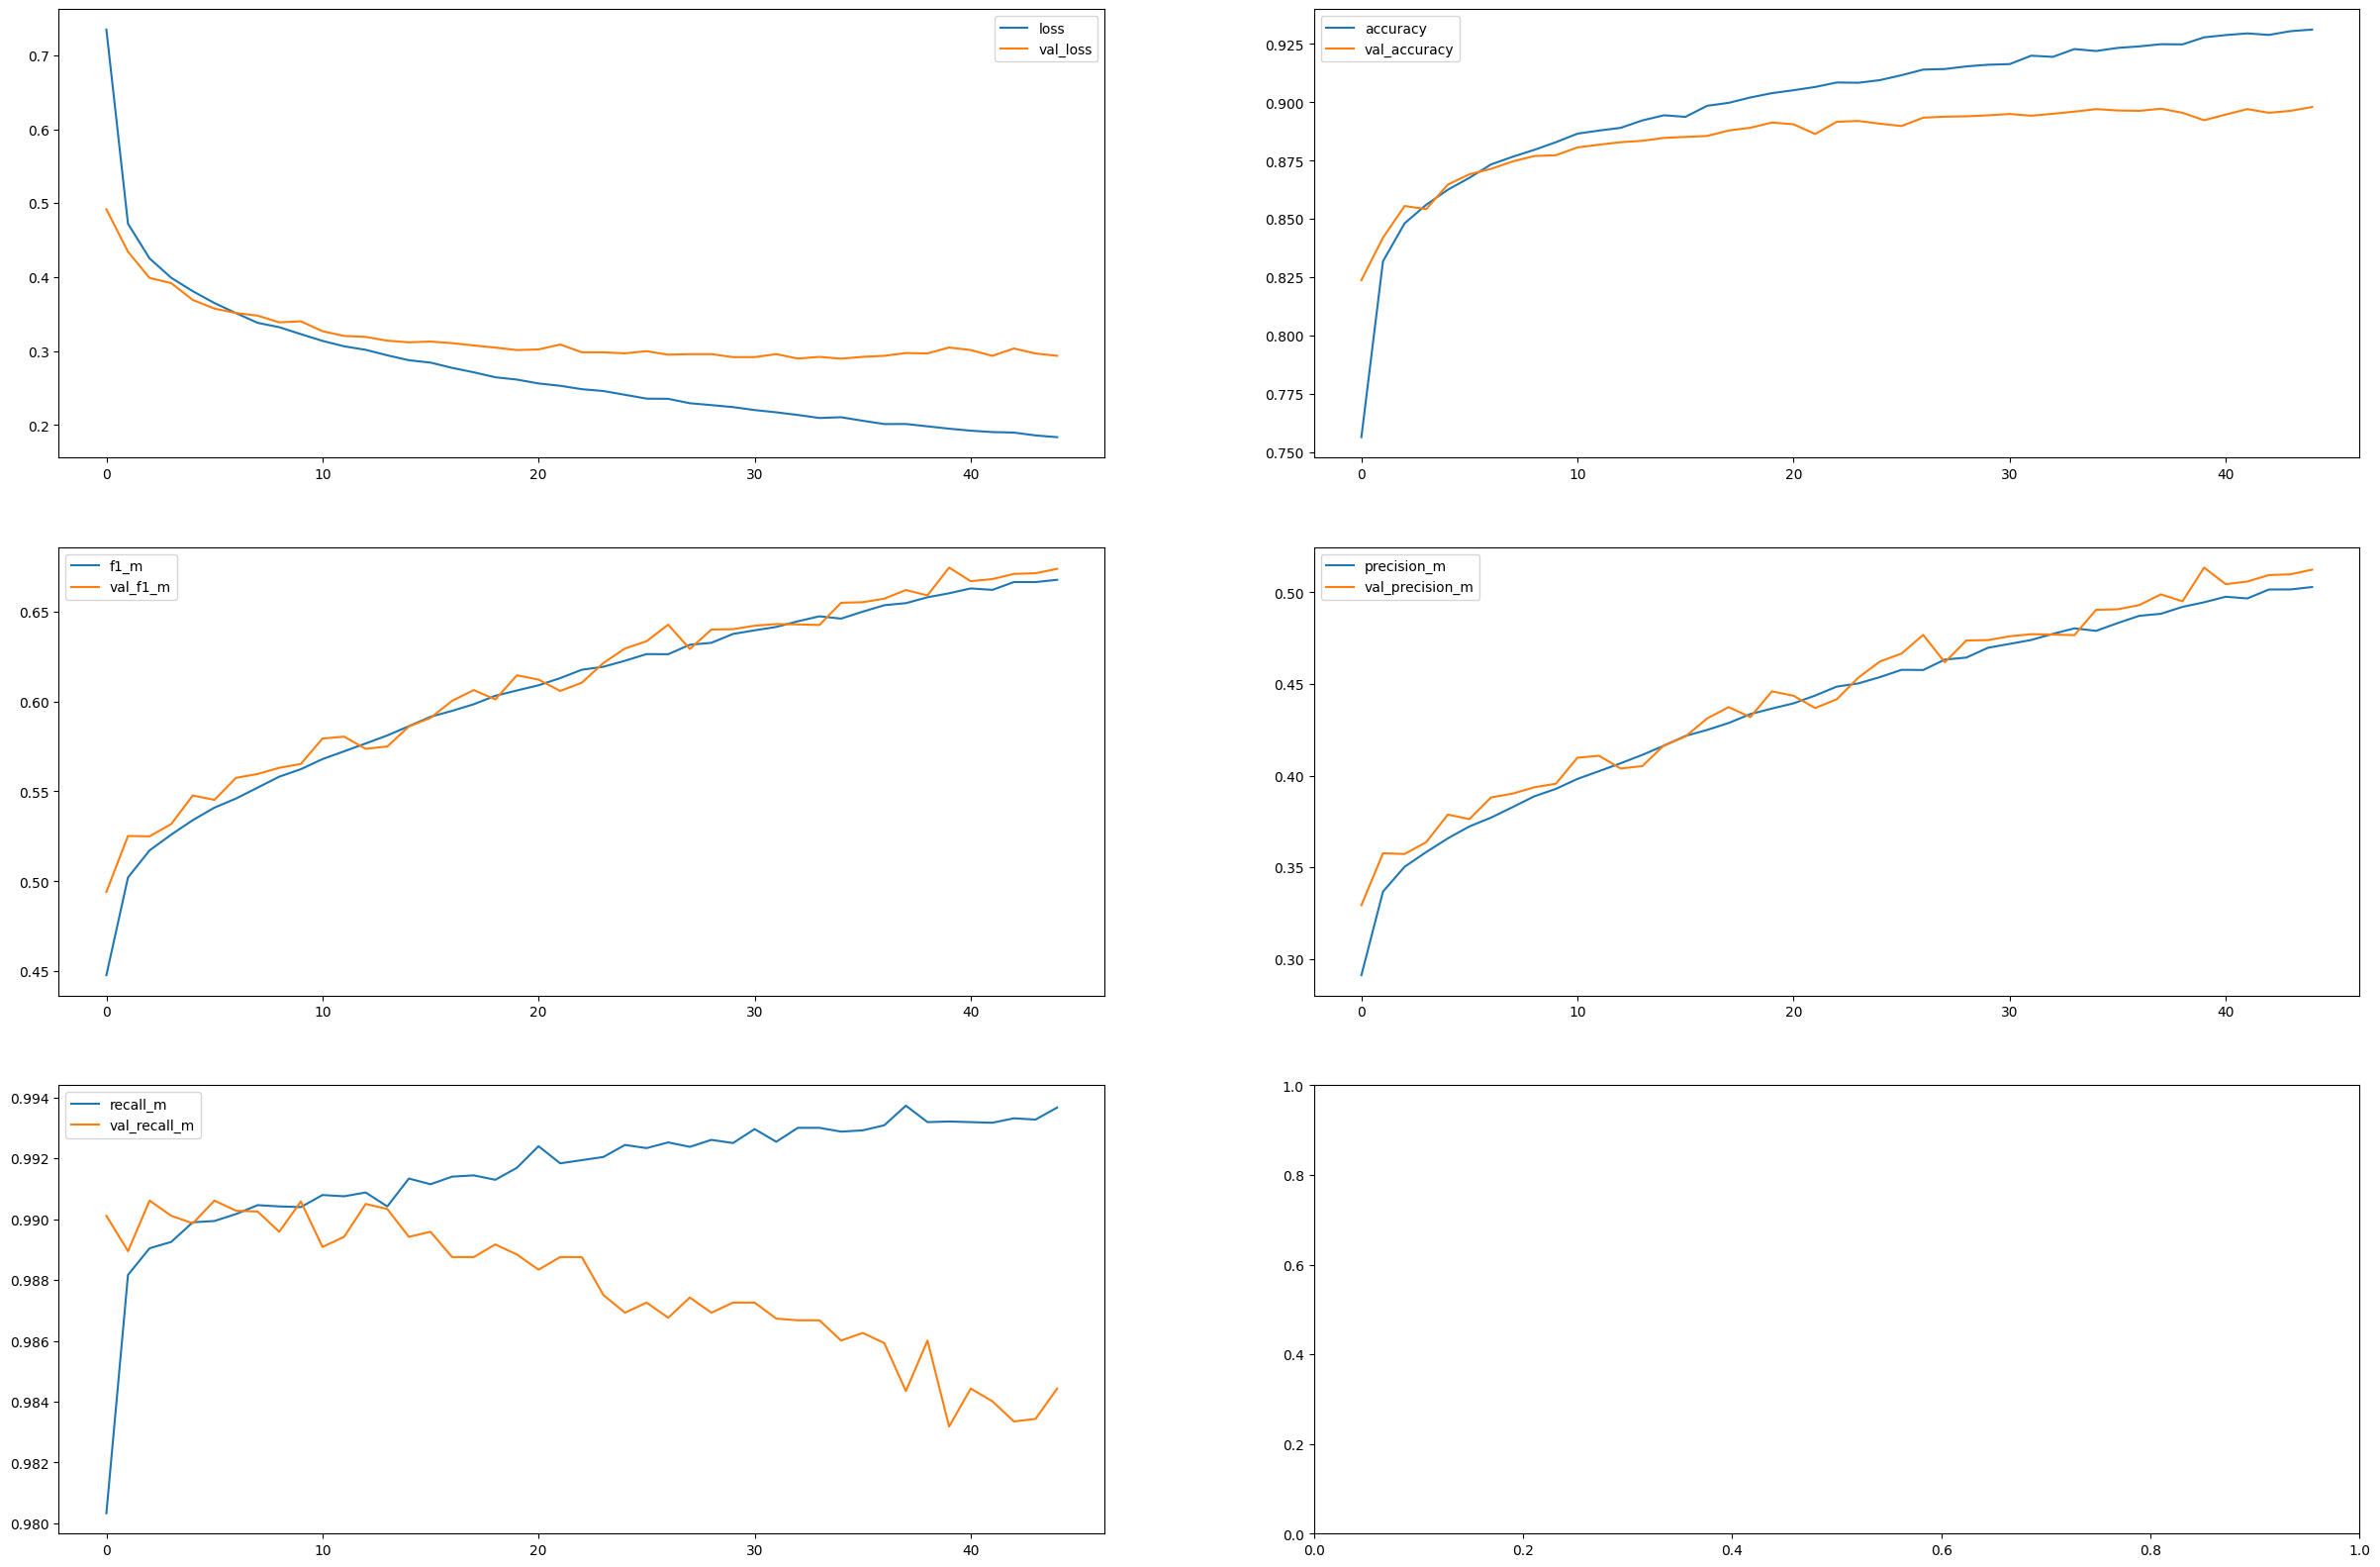

In [ ]:
K.clear_session()

model_1 = classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 1, 
                                    hidden_layers_units = [256],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.25,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = 0.001,
                                    decay = 0, 
                                    out_softmax = False
                                    )
model_1.summary()

model_1.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()])

metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_1.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_1.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1

It went much better! Droupout for regularization ROCKS!

Ok, we've started off so far on the right foot. But before adding another layer, let's try with ReLu as the activation function. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
375/375 - 4s - loss: 0.6065 - accuracy: 0.7901 - f1_m: 0.4883 - precision_m: 0.3258 - recall_m: 0.9840 - val_loss: 0.4355 - val_accuracy: 0.8486 - val_f1_m: 0.5441 - val_

KeyError: ''

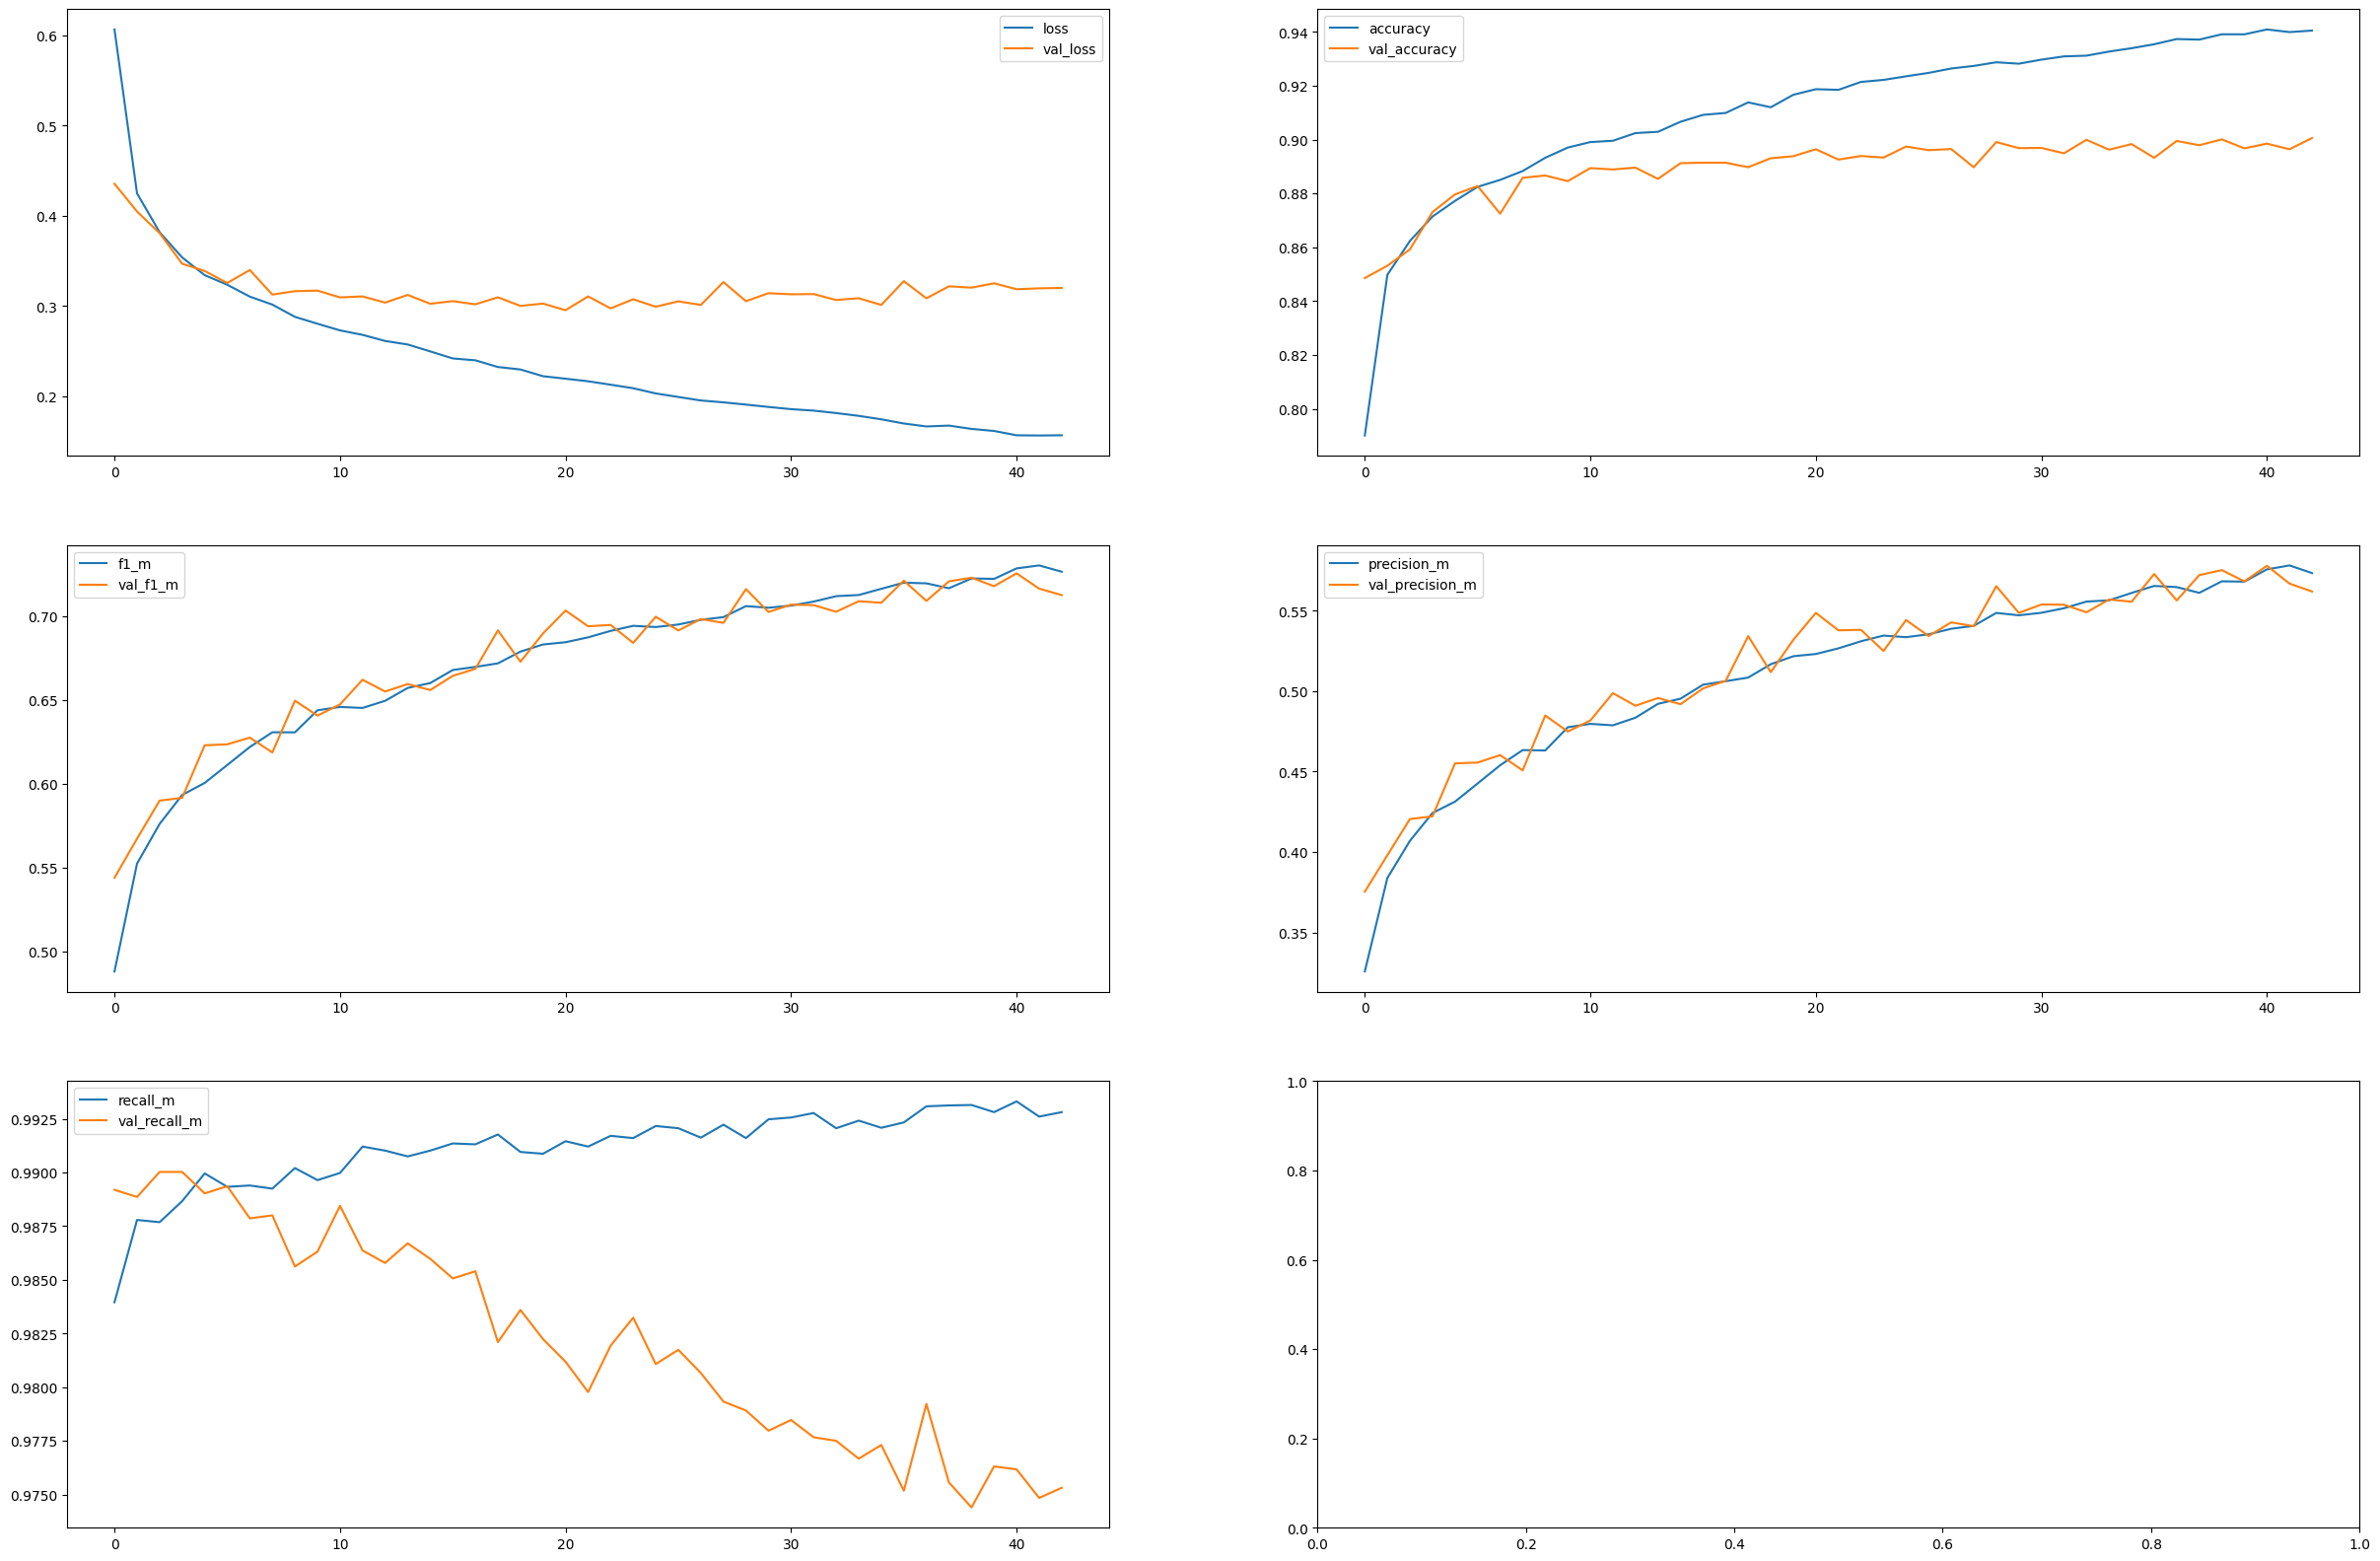

In [ ]:
K.clear_session()

model_1 = classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 1, 
                                    hidden_layers_units = [256],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.25,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = 0.001,
                                    decay = 0, 
                                    out_softmax = False
                                    )
model_1.summary()

model_1.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()])

metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_1.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_1.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1

Let's add another hidden layer but this time using the Model class of keras

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trai

KeyError: ''

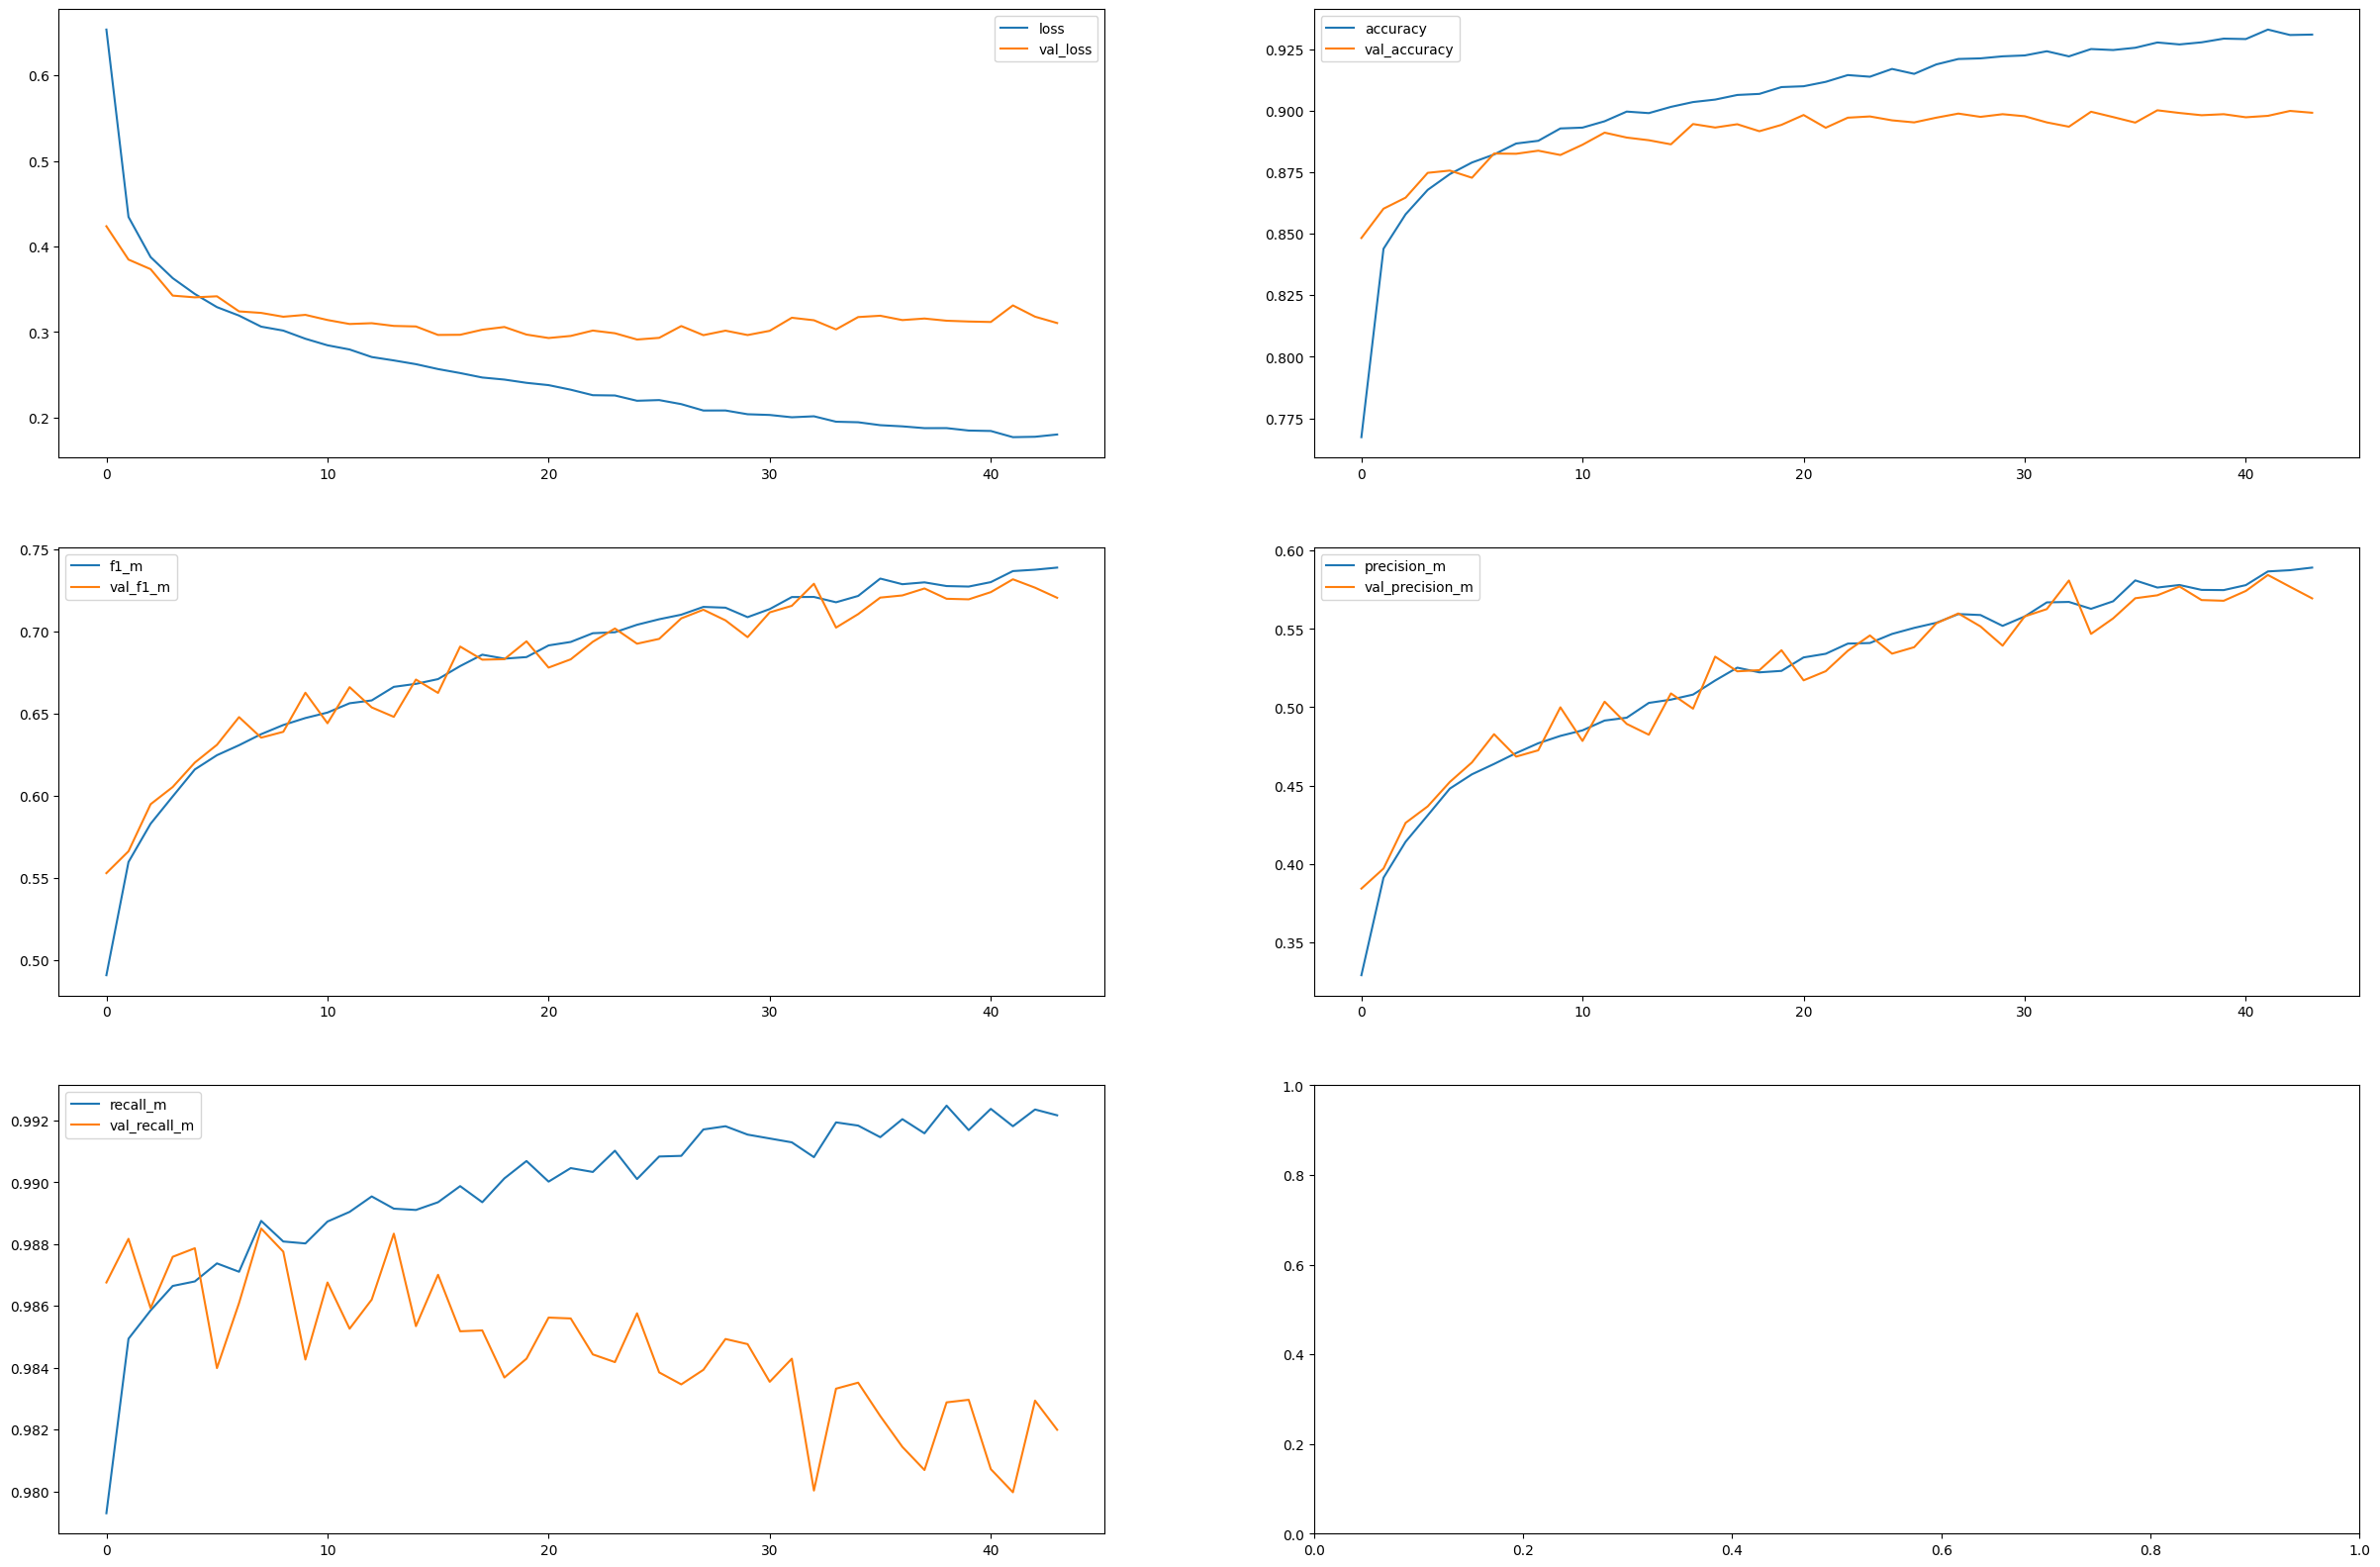

In [ ]:
K.clear_session()

model_2 = classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 2, 
                                    hidden_layers_units = [256, 128],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.25,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = 0.001,
                                    decay = 0, 
                                    out_softmax = False
                                    )
model_2.summary()

model_2.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()])

metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_2.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_2.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1

It still could be better. Let's try batch normalization to improve the overfitting we see from as early as the tenth epoch. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

KeyError: ''

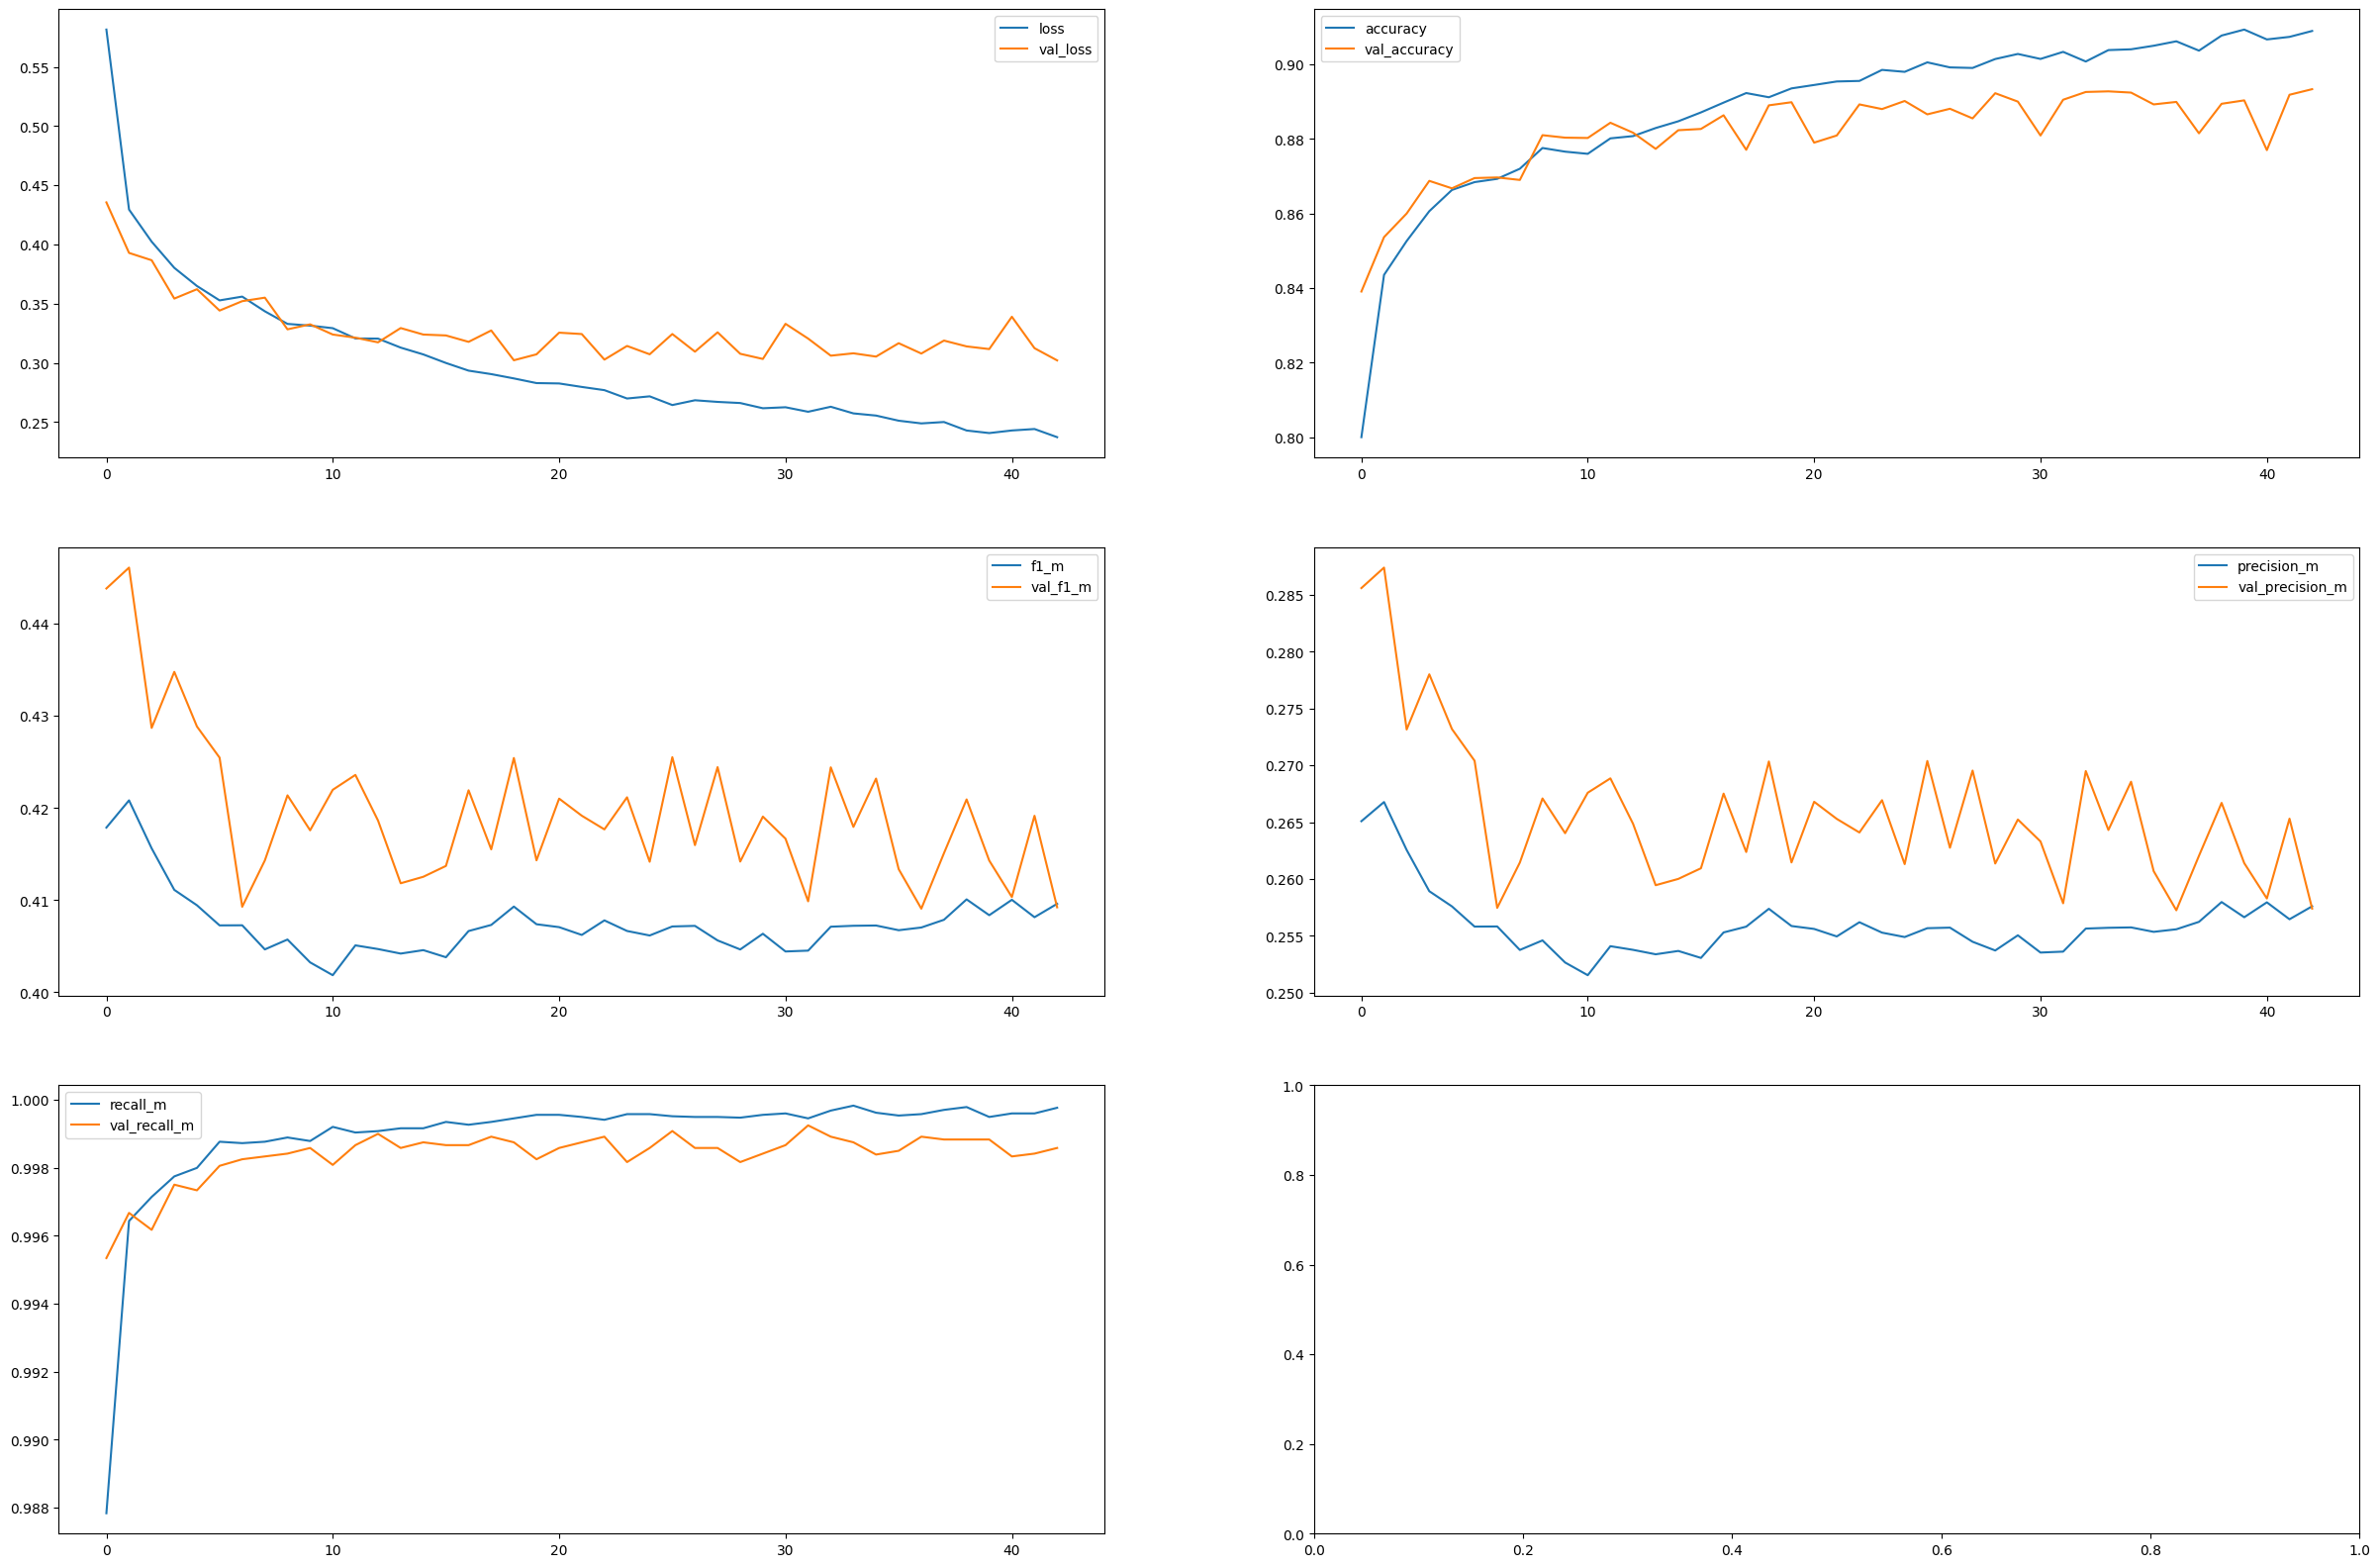

In [ ]:
K.clear_session()

model_2 = classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 2, 
                                    hidden_layers_units = [256, 128],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.25,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=True,
                                    lr = 0.001,
                                    decay = 0, 
                                    out_softmax = False
                                    )
model_2.summary()

model_2.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()])

metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_2.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_2.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1

Indeed, it was a little bit better. Let's keep on using batch normalization. 

Even though we can see a clear overfittin, it seems as if the model can still improve a little bit more with additional epochs. 

Let's add anothet layer, just in case we can achieve a better accuracy in the validation. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

KeyError: ''

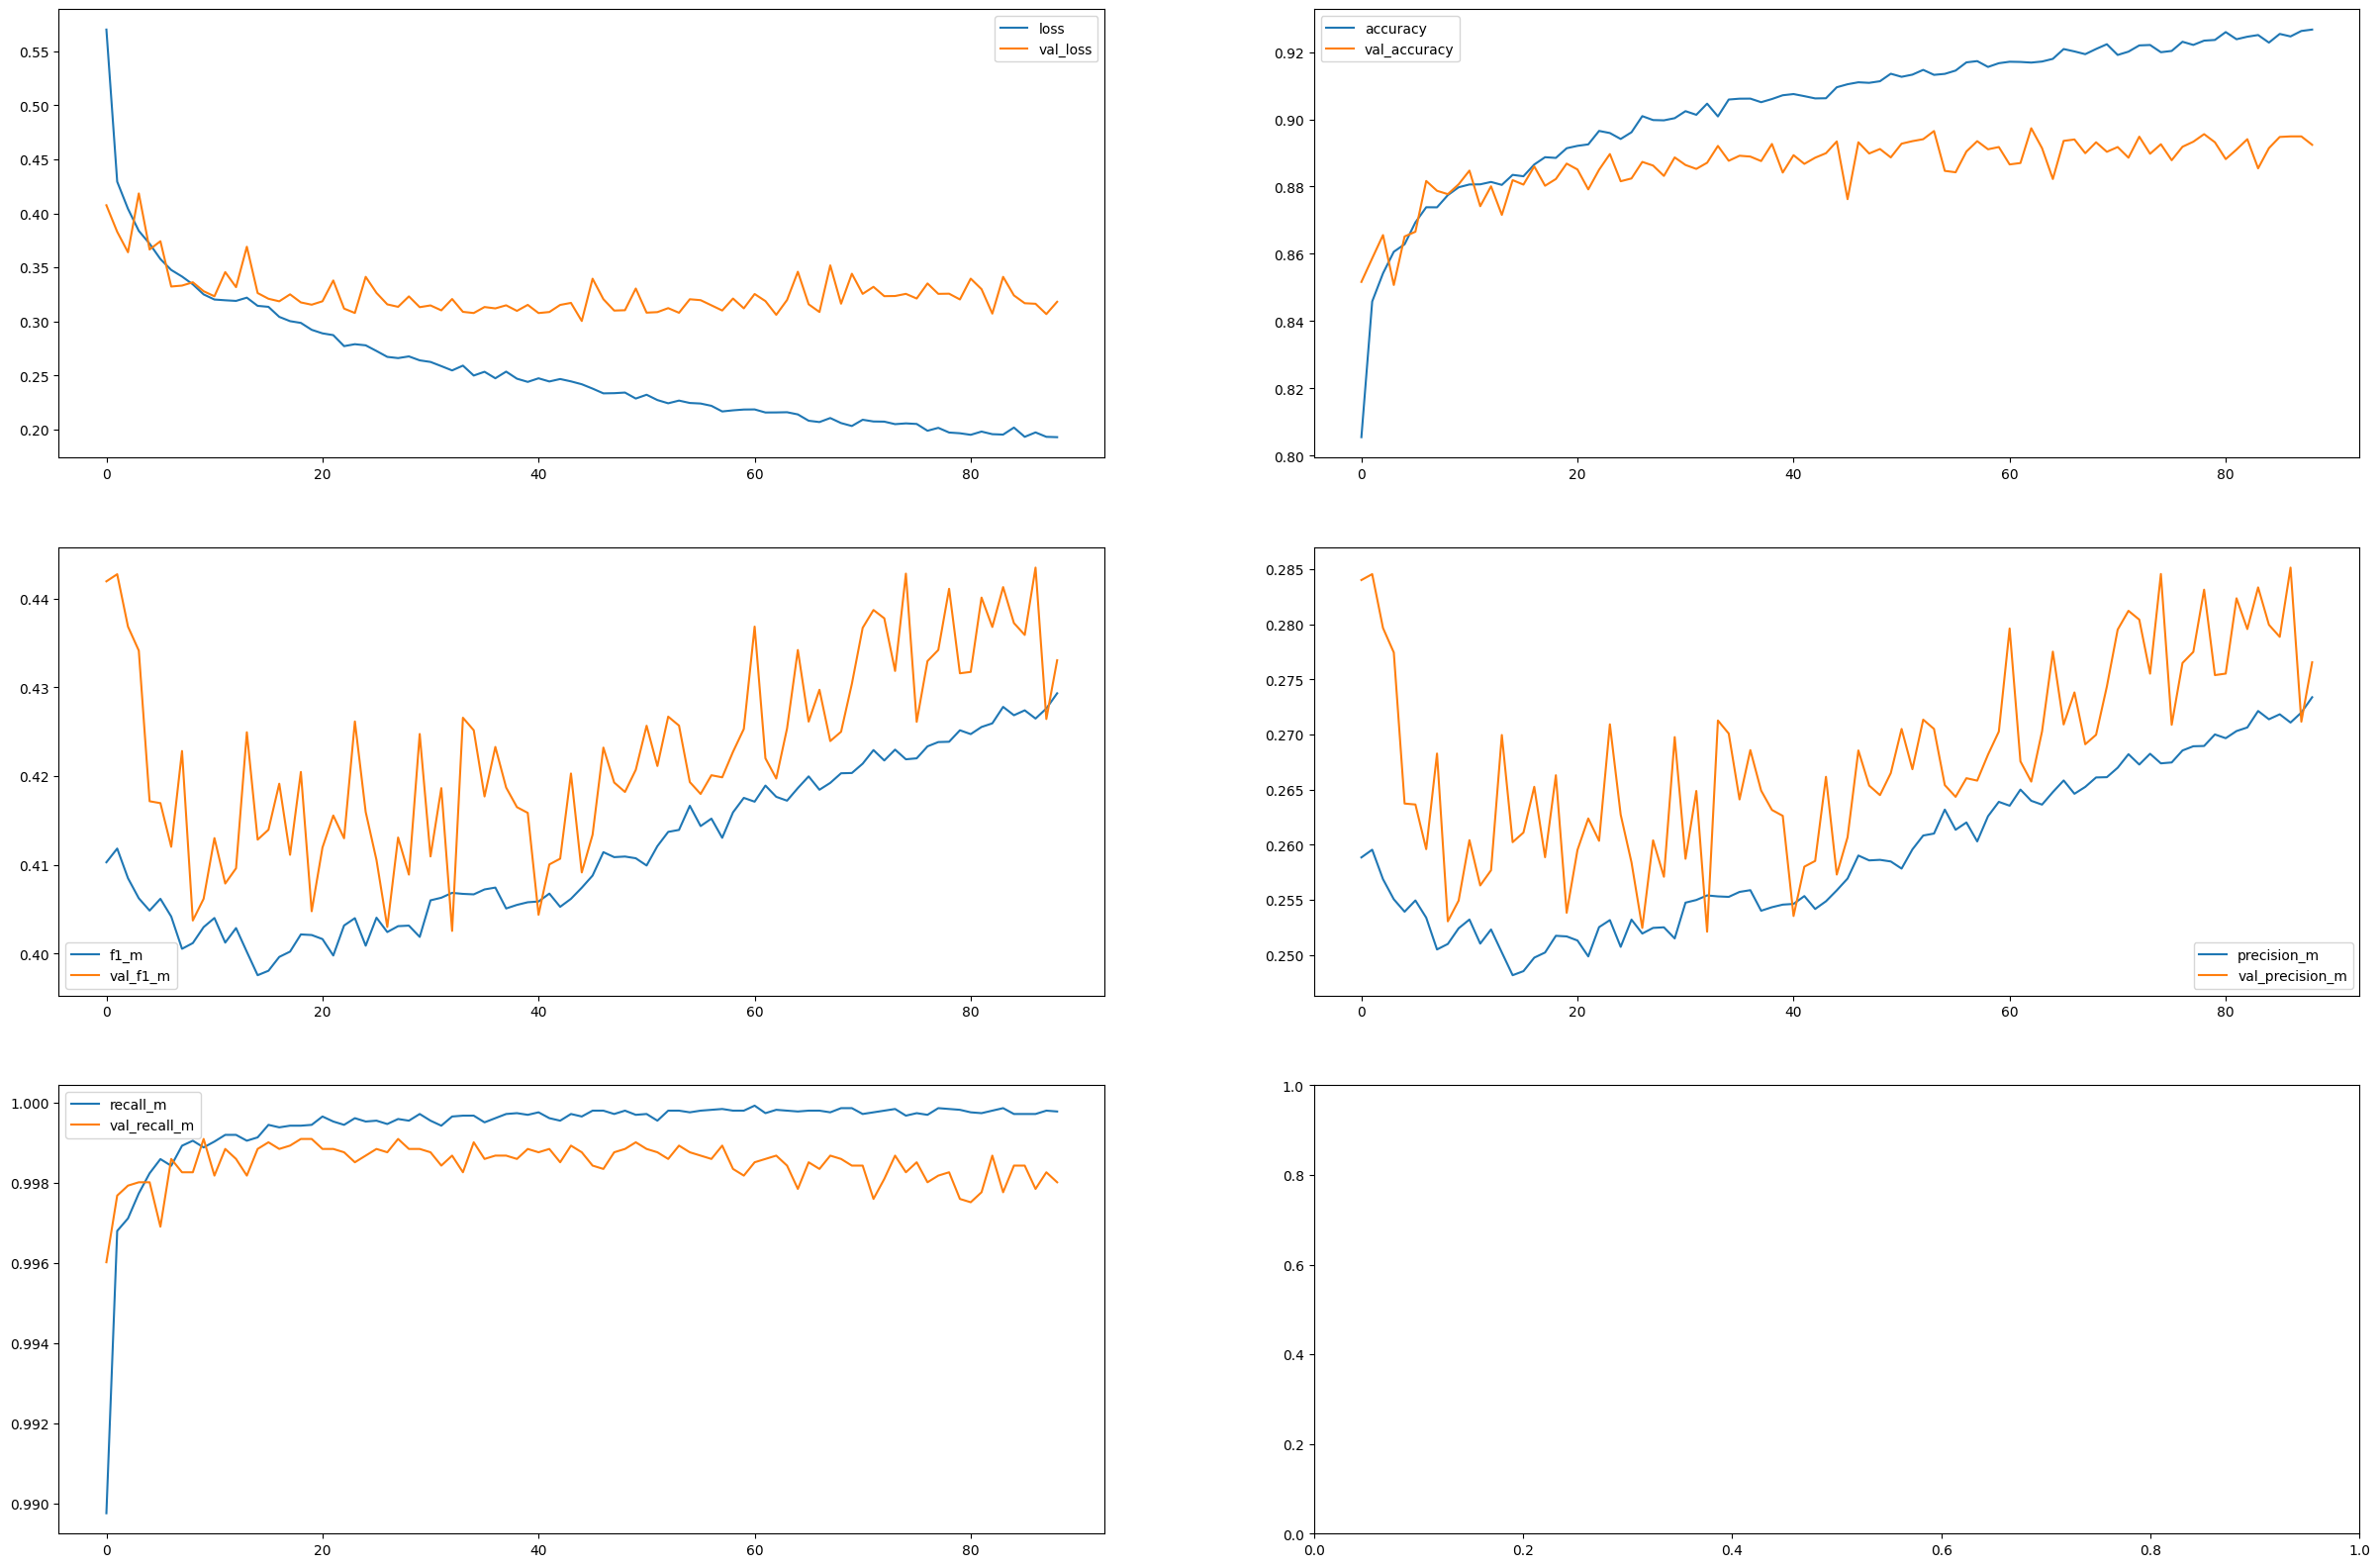

In [14]:
K.clear_session()

model_3 = classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 2, 
                                    hidden_layers_units = [256, 128, 64],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.25,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=True,
                                    lr = 0.001,
                                    decay = 0, 
                                    out_softmax = False
                                    )
model_3.summary()

model_3.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()])

metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_3.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_3.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1

We do not see a real improvement in accuracy. So let's keep two layers. 

In [17]:
K.clear_session()

model_2 = classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 2, 
                                    hidden_layers_units = [256, 128],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = [0.2,0.2],
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[True, False],
                                    lr = 0.001,
                                    decay = 0, 
                                    out_softmax = True
                                    )
model_2.summary()

model_2.fit(    x_train, 
                y_train_categorical,
                epochs=500, batch_size=128, 
                verbose=2, 
                validation_data = (x_val, y_val_categorical),
                callbacks=[callback_EarlyStopping()])

metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 20))
k = 0
for i in range(4):
    for j in range(2):
        axis[i,j].plot(model_2.history.history[metrics[k][0][0]], label = metrics[k][0][1])
        axis[i,j].plot(model_2.history.history[metrics[k][1][0]], label = metrics[k][1][1])
        axis[i,j].legend()
        k += 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

ValueError: in user code:

    File "C:\Users\Facu Molina\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Facu Molina\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Facu Molina\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Facu Molina\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Facu Molina\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'dropout' (type Dropout).
    
    `rate` must be a scalar or scalar tensor. Received: rate=ListWrapper([0.2, 0.2])
    
    Call arguments received by layer 'dropout' (type Dropout):
      • inputs=tf.Tensor(shape=(128, 256), dtype=float32)
      • training=True
